In [1]:
# IMPORTS FROM LABS #
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv, rgb2gray
from skimage.morphology import erosion, closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours
from sklearn.cluster import KMeans
import numpy as np
import cv2 
import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

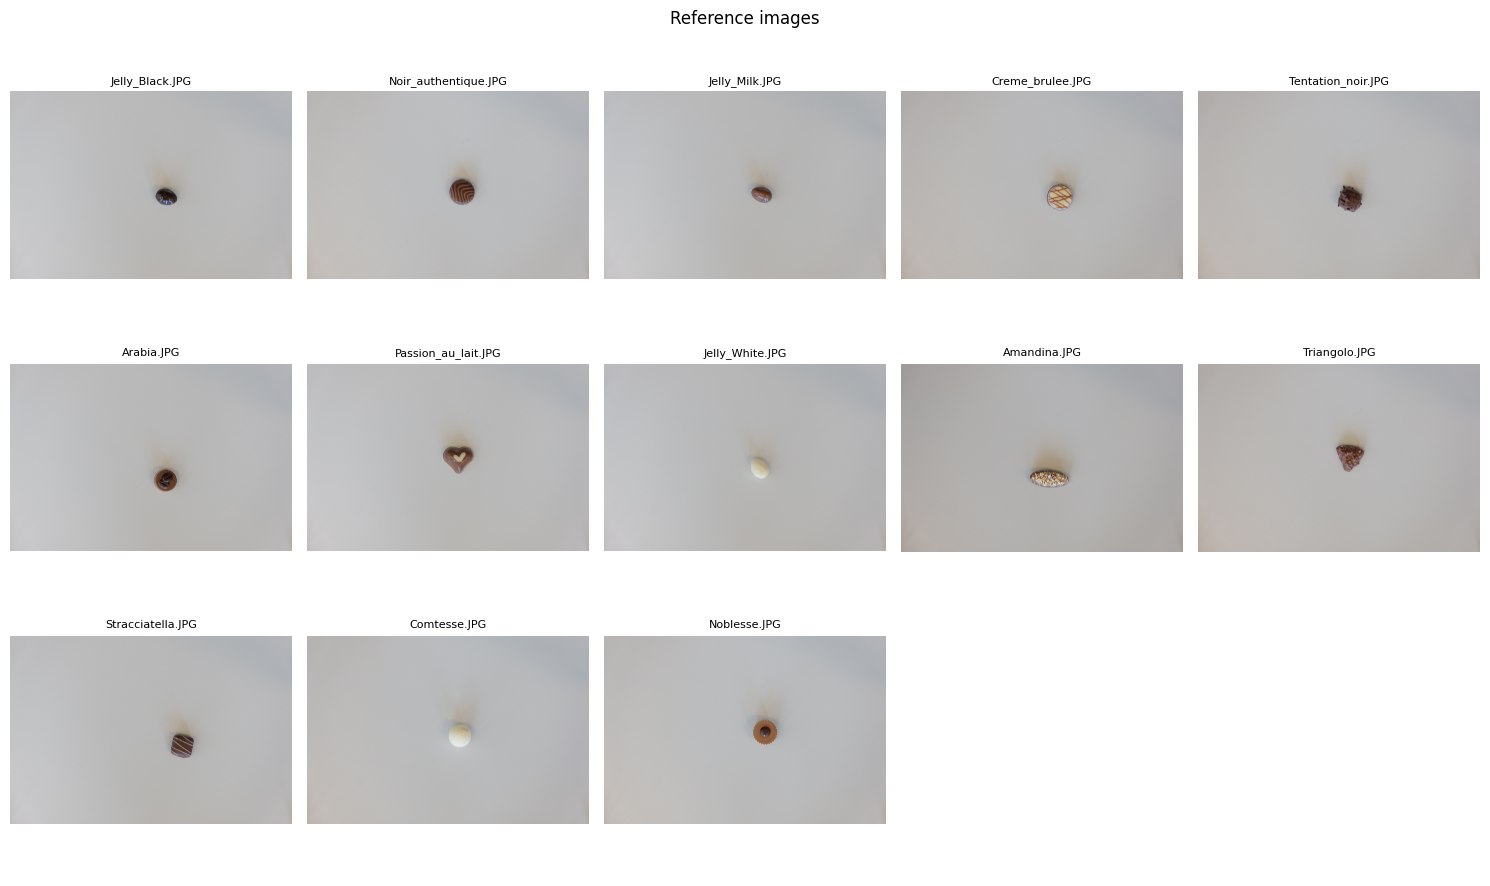

In [2]:
path_ref = '/Users/louiscuendet/Documents/EPFL NEURO-X /Image Analysis and Pattern Recognition/dataset_project_iapr2025/references'


jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

# Define grid size (square-ish)
cols = 5
rows = (n_images + cols - 1) // cols  # Round up division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

plt.suptitle('Reference images')
reference_images = []
for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        reference_images.append(img)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

In [3]:
def segmentation(img):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to Grayscale ---
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # --- 3. Blur to Reduce Noise ---
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(blurred, threshold1=20, threshold2=50)

    # --- 5. Dilate to Connect Broken Edges ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # --- 6. Morphological Closing to Fill Gaps ---
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    if contours:
        cnt = max(contours, key=cv2.contourArea)
    else:
        return

    area = cv2.contourArea(cnt)
    # Skip tiny noise
    if area < 2000:
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            (x, y), (MA, ma), angle = ellipse
            if MA > 5 and ma > 5:
                cv2.ellipse(mask, ellipse, 255, -1)
    else:
        # If not enough points, fall back to filled contour
        cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    h = h + 30 
    w = w + 30

    # Crop each object from the original image
    chocolate_crop = segmented_objects[y-30:y+h, x-30:x+w]

    return chocolate_crop

def plot_choc(img):
    plt.figure()
    plt.imshow(img)
    plt.title(f"Chocolate #{i+1}")
    plt.axis('off')
    plt.show()

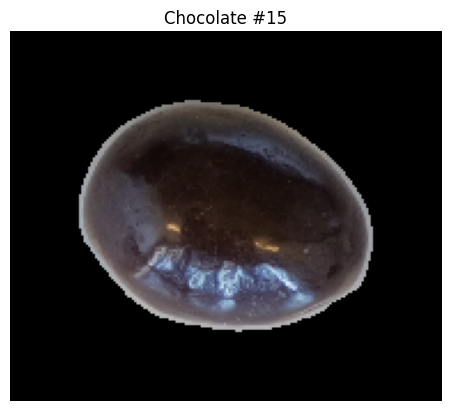

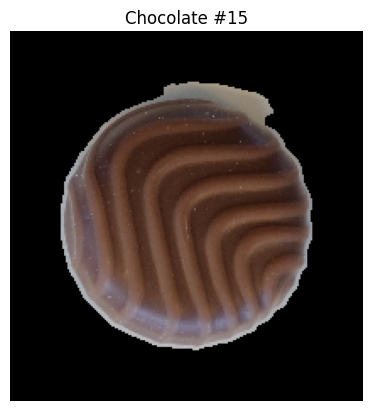

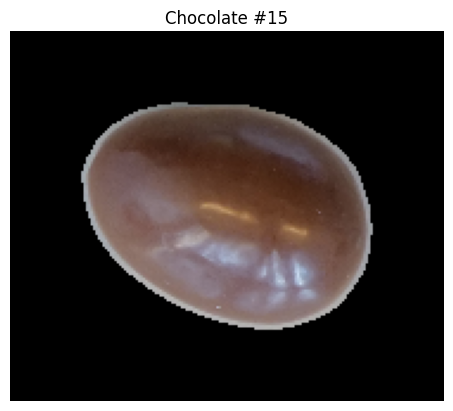

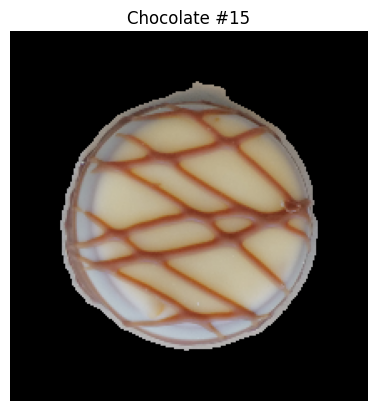

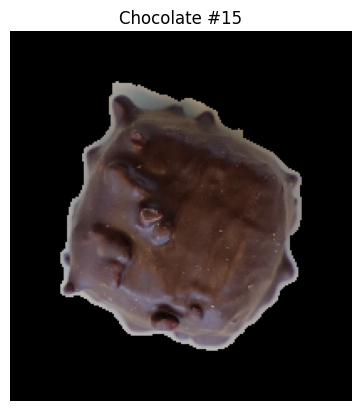

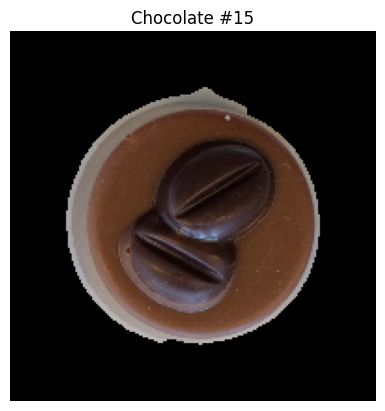

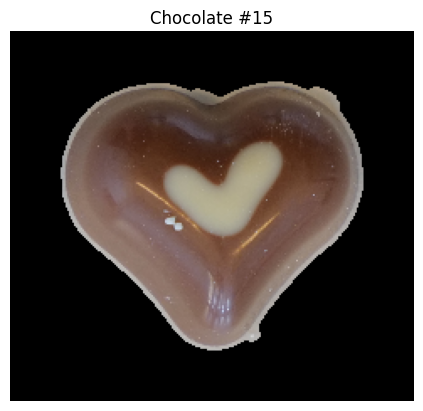

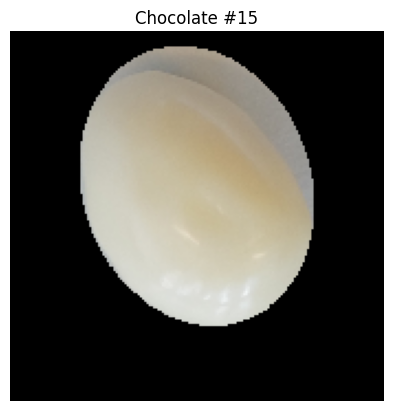

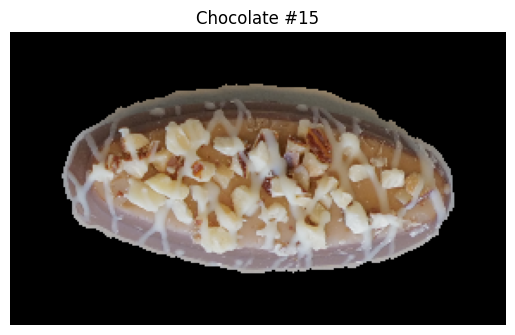

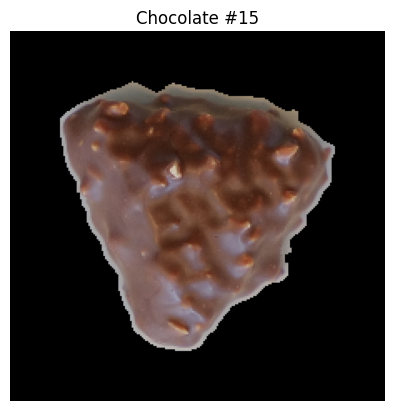

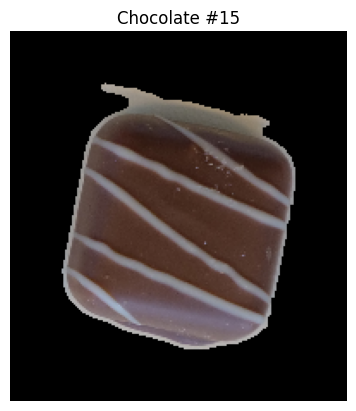

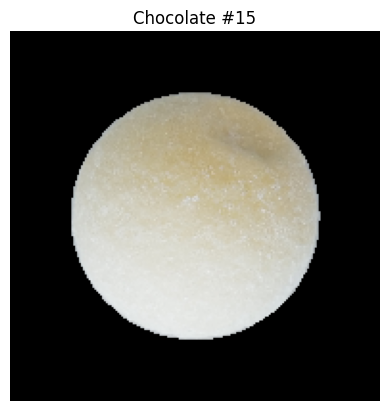

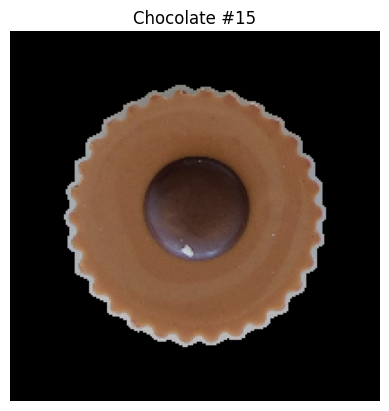

In [4]:
for img in reference_images:
    res = segmentation(img)
    plot_choc(res)